<a href="https://colab.research.google.com/github/GiovanniBarnaba/Deep_Learning/blob/main/DLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project: Landsat Images Classification

Authors: 
* Giovanni Barnaba 5105703
* Matteo Fossati 5110618

Dataset:
[Land-Use Scene Classification](https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification/code)

# Requirements:

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install d2l==1.0.0a1.post0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision
from torch.utils import data
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib
from torchvision import transforms, datasets
import torch.nn as nn
from torch.nn import functional as F
from sklearn.model_selection import KFold
d2l.use_svg_display()
%matplotlib inline
import collections
from matplotlib import pyplot as plt
import pathlib
import torch
from torchvision import datasets, transforms

d2l.use_svg_display()

#Exploratory analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## formal description of the dataset

*UC Merced Land Use Dataset, October 28, 2010*

- This is a 21 class land use image dataset meant for research purposes.

- Each image measures 256x256 pixels.

- The images were manually extracted from large images from the USGS National Map Urban Area Imagery collection for various urban areas around the country. The pixel resolution of this public domain imagery is 1 foot.

## get an overview of the data through the csv files

In this section we would like to know if the classes are balanced in the dataset

In [ ]:
#train dataframe
csv_dataset_train = pd.read_csv('/content/drive/My Drive/deep_learning/PROGETTO/archive/train.csv')
#let's see the number of classes that we have
classes_numb = csv_dataset_train.Label.nunique()
classes_names = csv_dataset_train.ClassName.unique()
print(f'The dataset is composed by {classes_numb} classes that are: ')
print(*classes_names, sep = "\n")

#test dataframe
test_data = pd.read_csv('/content/drive/My Drive/deep_learning/PROGETTO/archive/test.csv')
#validation dataframe
vali_data = pd.read_csv('/content/drive/My Drive/deep_learning/PROGETTO/archive/validation.csv')

The dataset is composed by 21 classes that are: 
runway
intersection
agricultural
chaparral
airplane
storagetanks
tenniscourt
overpass
harbor
buildings
mediumresidential
baseballdiamond
golfcourse
freeway
sparseresidential
river
mobilehomepark
forest
beach
parkinglot
denseresidential


In [ ]:
csv_dataset_train.drop('Unnamed: 0', axis=1, inplace=True)
test_data.drop('Unnamed: 0', axis=1, inplace=True)
vali_data.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
csv_dataset_train.head()

,Filename,Label,ClassName
0,runway/runway_000259.png,16,runway
1,intersection/intersection_000348.png,10,intersection
2,agricultural/agricultural_000025.png,0,agricultural
3,chaparral/chaparral_000195.png,5,chaparral
4,airplane/airplane_000260.png,1,airplane


Let's verify if the train dataset is balanced in each class graphically:

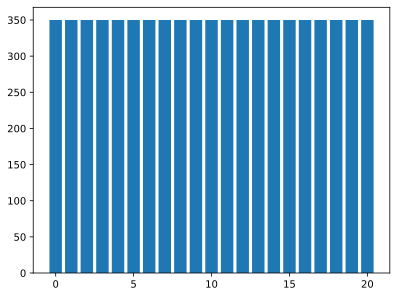

16    350
2     350
14    350
3     350
7     350
12    350
15    350
17    350
8     350
9     350
11    350
10    350
4     350
20    350
13    350
19    350
18    350
1     350
5     350
0     350
6     350
Name: Label, dtype: int64

In [ ]:
d = collections.Counter(csv_dataset_train["Label"])
plt.bar(d.keys(), d.values())
plt.show()

csv_dataset_train["Label"].value_counts()

Let's apply the same procedure to the test dataset:

In [ ]:
test_data.head()

,Filename,Label,ClassName
0,river/river_000149.png,15,river
1,mediumresidential/mediumresidential_000335.png,11,mediumresidential
2,overpass/overpass_000338.png,13,overpass
3,storagetanks/storagetanks_000307.png,18,storagetanks
4,river/river_000370.png,15,river


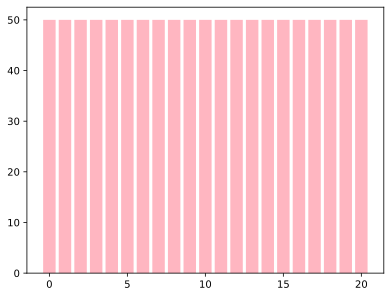

15    50
1     50
2     50
0     50
14    50
8     50
17    50
12    50
7     50
10    50
16    50
11    50
3     50
6     50
4     50
19    50
5     50
9     50
18    50
13    50
20    50
Name: Label, dtype: int64

In [ ]:
d = collections.Counter(test_data["Label"])
plt.bar(d.keys(), d.values(),color = "lightpink")
plt.show()

test_data["Label"].value_counts()

Finally let's apply it to the Validation csv

In [ ]:
vali_data.head()

,Filename,Label,ClassName
0,mediumresidential/mediumresidential_000305.png,11,mediumresidential
1,buildings/buildings_000191.png,4,buildings
2,tenniscourt/tenniscourt_000224.png,19,tenniscourt
3,denseresidential/denseresidential_000436.png,6,denseresidential
4,baseballdiamond/baseballdiamond_000280.png,2,baseballdiamond


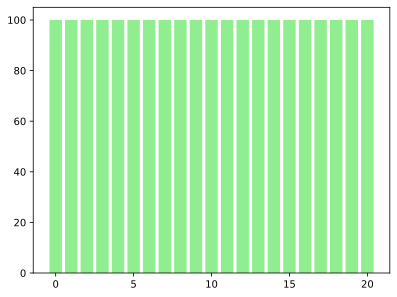

11    100
16    100
17    100
9     100
5     100
18    100
1     100
8     100
3     100
7     100
12    100
4     100
13    100
15    100
14    100
20    100
10    100
2     100
6     100
19    100
0     100
Name: Label, dtype: int64

In [ ]:
d = collections.Counter(vali_data["Label"])
plt.bar(d.keys(), d.values(),color = "lightgreen")
plt.show()

vali_data["Label"].value_counts()

We can conclude that all the classes have the same amount of images (350 in the train dataset, 50 in the test datset and 100 in the validation dataset).

# Paths

Prepare the paths for the analysis 

In [ ]:
#DATA PATH
Train_Data_Path = ('/content/drive/My Drive/deep_learning/PROGETTO/archive/images_train_test_val/train')
Test_Data_Path = ("/content/drive/My Drive/deep_learning/PROGETTO/archive/images_train_test_val/test")
Validation_Data_Path = ("/content/drive/My Drive/deep_learning/PROGETTO/archive/images_train_test_val/validation")

## visualize images for each class

In [ ]:
list_labels = [
    "agricultural",
    "airplane",
    "baseballdiamond",
    "beach",
    "buildings",
    "chaparral",
    "denseresidential",
    "forest",
    "freeway",
    "golfcourse",
    "intersection",
    "mediumresidential",
    "mobilehomepark",
    "overpass",
    "parkinglot",
    "river",
    "runway",
    "sparseresidential",
    "storagetanks",
    "tenniscourt",
    "harbor"]

In [ ]:
x = '/content/drive/My Drive/deep_learning/PROGETTO/archive/images_train_test_val/train/' 
data_dir = pathlib.Path(x)

In [ ]:
#create a unique list made by lists with all the classes
up_list = []
for i in range(21):
   up_list.append(list(data_dir.glob(list_labels[i]+"/*")))

In [ ]:
from matplotlib.image import imread

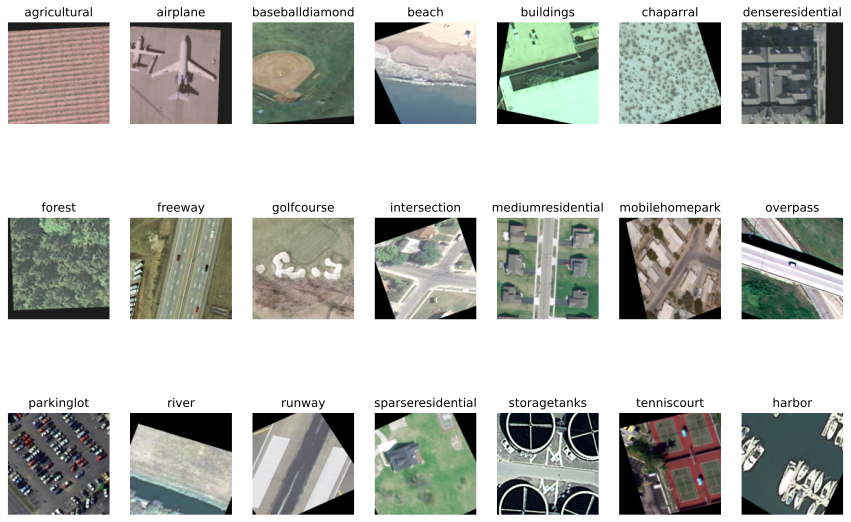

In [ ]:
#print the first image for each class
plt.figure(figsize=(15,10))
for i in range(21):
  plt.subplot(3,7,i+1)
  readable= up_list[i][0]
  plt.title(list_labels[i])
  image = imread(readable)
  plt.imshow(image) 
  plt.axis("off")

# Modelling

Data Preparation

In [ ]:
#simple data transformation and augmentation
trasforms = transforms.Compose([
    transforms.Resize([100,100]),
    transforms.ToTensor() ])

#the augmentation will be changed further in the analysis 
data_augmentation = transforms.Compose([
        transforms.Resize([100,100]),
        transforms.ToTensor()
        ])

In [ ]:
Train_Data = datasets.ImageFolder(root=Train_Data_Path, transform = data_augmentation)
print(len(Train_Data))
print(type(Train_Data))
Test_Data = datasets.ImageFolder(root=Test_Data_Path ,transform=trasforms)
print(Test_Data)
print(type(Test_Data))
Validation_Data = datasets.ImageFolder(root=Validation_Data_Path ,transform=trasforms)
print(Validation_Data)
print(type(Validation_Data))

7357
<class 'torchvision.datasets.folder.ImageFolder'>
Dataset ImageFolder
    Number of datapoints: 1050
    Root location: /content/drive/My Drive/deep_learning/PROGETTO/archive/images_train_test_val/test
    StandardTransform
Transform: Compose(
               Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
<class 'torchvision.datasets.folder.ImageFolder'>
Dataset ImageFolder
    Number of datapoints: 2100
    Root location: /content/drive/My Drive/deep_learning/PROGETTO/archive/images_train_test_val/validation
    StandardTransform
Transform: Compose(
               Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
<class 'torchvision.datasets.folder.ImageFolder'>


In [ ]:
batch_size = 32

In [ ]:
#prepare the dataloaders
Train_loader = data.DataLoader(Train_Data, batch_size=batch_size,shuffle = True,num_workers=2)
Test_loader = data.DataLoader(Test_Data, batch_size=batch_size,shuffle = True,num_workers=2)
Validation_loader = data.DataLoader(Validation_Data, batch_size=batch_size,shuffle = True,num_workers=2)

# Training Functions

Prepare some functions to train the models and evaluate the accracy of each one. 

In [ ]:
labels_dictionary = {
    "agricultural": 0,
    "airplane": 1,
    "baseballdiamond": 2,
    "beach": 3,
    "buildings": 4,
    "chaparral": 5,
    "denseresidential": 6,
    "forest": 7,
    "freeway": 8,
    "golfcourse": 9,
    "intersection": 10,
    "mediumresidential": 11,
    "mobilehomepark": 12,
    "overpass": 13,
    "parkinglot": 14,
    "river": 15,
    "runway": 16,
    "sparseresidential": 17,
    "storagetanks": 18,
    "tenniscourt": 19,
    "harbor": 20
}

swapped_dictionary = {v: k for k, v in labels_dictionary.items()}

In [ ]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:   
        y_hat = d2l.argmax(y_hat, axis=1)
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))
    
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]  

In [ ]:
def train(net, train_iter, val_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) 
    net.apply(init_weights)
    print('training on', device)
    net.to(device) 
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))
    loss = nn.CrossEntropyLoss()

    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim = [0,2],
                            legend=['train loss', 'train acc', 'val acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    best_val_acc = 0
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad(): 
                metric.add(l * X.shape[0], accuracy(y_hat, y) , X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]

            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None, None))
        val_acc = evaluate_accuracy_gpu(net, val_iter)
        animator.add(epoch + 1, (None, None, val_acc, None))
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = net.state_dict()
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'val acc {val_acc:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

# Data Augmentation

Let's apply different augmentation in order to improve the accuracy of the models.


In [ ]:
resize = transforms.Compose([
        transforms.Resize([100,100]),
        transforms.ToTensor() 
        ])

# Define the original dataset
original_dataset = datasets.ImageFolder(Train_Data_Path, transform=resize)
original_len = len(original_dataset)
print(f'Original dataset length: {original_len}')

# Define the data augmentation transforms
data_augmentation_1 =  transforms.Compose([
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=1),
        transforms.Resize([100,100]),
        transforms.ToTensor() 
        ])
data_augmentation_2 =  transforms.Compose([
        transforms.RandomRotation(degrees=45),
        transforms.Resize([100,100]),
        transforms.ToTensor() 
        ])

data_augmentation_3 =  transforms.Compose([
        transforms.RandomCrop([128,128]),
        transforms.Resize([100,100]),
        transforms.ToTensor() 
        ])

# Create the augmented dataset by applying the transforms on the original dataset
augmented_dataset_1 = datasets.ImageFolder(Train_Data_Path, transform=data_augmentation_1)
augmented_dataset_2 = datasets.ImageFolder(Train_Data_Path, transform=data_augmentation_2)
augmented_dataset_3 = datasets.ImageFolder(Train_Data_Path, transform=data_augmentation_3)

augmented_len_1 = len(augmented_dataset_1)
print(f'Augmented 1 dataset length: {augmented_len_1}')
augmented_len_2 = len(augmented_dataset_2)
print(f'Augmented 1 dataset length: {augmented_len_2}')
augmented_len_3 = len(augmented_dataset_3)
print(f'Augmented 1 dataset length: {augmented_len_3}')

# Concatenate the original and augmented datasets to create a new dataset
new_dataset = torch.utils.data.ConcatDataset([original_dataset, augmented_dataset_1, augmented_dataset_2, augmented_dataset_3])
new_len = len(new_dataset)
print(f'New dataset length: {new_len}')

Original dataset length: 7357
Augmented 1 dataset length: 7357
Augmented 1 dataset length: 7357
Augmented 1 dataset length: 7357
New dataset length: 29428


In [ ]:
# build the new dataloaders
batch_size=32
New_Train_loader = data.DataLoader(new_dataset , batch_size, shuffle=True, num_workers= 2)
Validation_loader = data.DataLoader(Validation_Data, batch_size, shuffle=True, num_workers= 2)
Test_loader = data.DataLoader(Test_Data, batch_size, shuffle=True, num_workers= 2)

# CROSS VALIDATION

To check if the augmentation is working well we will use a K-Fold Cross Validation. In addition this procedure could be useful to select the best model in a more efficent way.

In [ ]:
def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    layer.reset_parameters()

In [ ]:
def Cross_Validation(net, data = Train_Data, folds = 3, epochs = 2, loss = nn.CrossEntropyLoss(),lr = 0.001 , batch = batch_size, seed = 104):
  # Configuration options
  k_folds = folds
  num_epochs = epochs
  loss_function = loss
  # For fold results
  results = {}
  # Set fixed random number seed
  torch.manual_seed(seed)
  # Prepare dataset.
  dataset = data
  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=k_folds, shuffle=True)
  print('--------------------------------')
  # K-fold Cross Validation model evaluation
  for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    batch_size = batch
    # Define data loaders for training and testing data in this fold
    testloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, sampler=test_subsampler)
    trainloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, sampler=train_subsampler)
    # Init the neural network
    network = net
    network.apply(reset_weights)
    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):
      print(f'Starting epoch {epoch+1}')
      # Set current loss value
      current_loss = 0.0
      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs, targets = data
        # Zero the gradients
        optimizer.zero_grad()
        # Perform forward pass
        outputs = network(inputs)
        # Compute loss
        loss = loss_function(outputs, targets)
        # Perform backward pass
        loss.backward()
        # Perform optimization
        optimizer.step()
        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            current_loss = 0.0
    print('Training process has finished.')
    print('Starting testing')
    # Evaluationfor this fold
    correct, total = 0, 0
    with torch.no_grad():
      # Iterate over the test data and generate predictions
      for i, data in enumerate(testloader, 0):
        # Get inputs
        inputs, targets = data
        # Generate outputs
        outputs = network(inputs)
        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
  print('--------------------------------')
  sum = 0.0
  for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
  print(f'Average: {sum/len(results.items())} %')

# CNN

We now start introducion models based on convolutional neural network. CNN in broadly used for image classification beacuase Its built-in convolutional layer reduces the high dimensionality of images without losing its information. we are going to introduce models with different complexity in order to find the one that perform better in our scenario.

# LeNet



LeNet is a relatively simple and one of the first CNN models introduced, due to his simple architecture this wil be probabily a starting point to increase accuracy in more complicate models that will be implemented later. 

In [ ]:
import torch.nn as nn
import torch

class LeNet(nn.Module):
  '''
    Convolutional Neural Network
  '''
  def __init__(self):
    super().__init__()
    self.layers = torch.nn.Sequential(
        nn.Conv2d(3, 6, kernel_size=5, padding=2), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(8464, 120), nn.Sigmoid(),
        nn.Linear(120, 64), nn.Sigmoid(),
        nn.Linear(64, 21))

  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

In [ ]:
X_2 = torch.rand(size=(1, 3, 100,100))
for layer in LeNet().layers:
    X_2 = layer(X_2)
    print(layer.__class__.__name__,'output shape:\t', X_2.shape)

Conv2d output shape:	 torch.Size([1, 6, 100, 100])
Sigmoid output shape:	 torch.Size([1, 6, 100, 100])
AvgPool2d output shape:	 torch.Size([1, 6, 50, 50])
Conv2d output shape:	 torch.Size([1, 16, 46, 46])
Sigmoid output shape:	 torch.Size([1, 16, 46, 46])
AvgPool2d output shape:	 torch.Size([1, 16, 23, 23])
Flatten output shape:	 torch.Size([1, 8464])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 64])
Sigmoid output shape:	 torch.Size([1, 64])
Linear output shape:	 torch.Size([1, 21])


In [ ]:
#CV with not augmented data
Cross_Validation(net = LeNet())

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
Starting epoch 2
Training process has finished.
Starting testing
Accuracy for fold 0: 4 %
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1
Starting epoch 2
Training process has finished.
Starting testing
Accuracy for fold 1: 4 %
--------------------------------
FOLD 2
--------------------------------
Starting epoch 1
Starting epoch 2
Training process has finished.
Starting testing
Accuracy for fold 2: 4 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS
--------------------------------
Fold 0: 4.606604158173664 %
Fold 1: 4.567699836867863 %
Fold 2: 4.241435562805873 %
Average: 4.471913185949133 %


In [ ]:
#CV with augmented data
Cross_Validation(net = LeNet(),data = new_dataset)

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 3.051
Starting epoch 2
Loss after mini-batch   500: 3.048
Training process has finished.
Starting testing
Accuracy for fold 0: 4 %
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 3.051
Starting epoch 2
Loss after mini-batch   500: 3.048
Training process has finished.
Starting testing
Accuracy for fold 1: 4 %
--------------------------------
FOLD 2
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 3.053
Starting epoch 2
Loss after mini-batch   500: 3.048
Training process has finished.
Starting testing
Accuracy for fold 2: 4 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS
--------------------------------
Fold 0: 4.740061162079511 %
Fold 1: 4.740544398001835 %
Fold 2: 4.720154959730859 %
Average: 4.733586839937401 %


As we can see from the previous outputs we can state that the augmentation can slightly improve the accuracy of the model, but the LeNet model is still not good eanough to make correct classification 

# AlexNet

This model is a more structured and deeper version of the LeNet which is based on more layers, the use of ReLU, adopt the MaxPooling and starts with a larger convolution window.

In [ ]:
Alexnet = nn.Sequential(
    # Here, we use a larger 11 x 11 window to capture objects. At the same
    # time, we use a stride of 4 to greatly reduce the height and width of the
    # output. Here, the number of output channels is much larger than that in
    # LeNet
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Make the convolution window smaller, set padding to 2 for consistent
    # height and width across the input and output, and increase the number of
    # output channels
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(), 
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Use three successive convolutional layers and a smaller convolution
    # window. Except for the final convolutional layer, the number of output
    # channels is further increased. Pooling layers are not used to reduce the
    # height and width of input after the first two convolutional layers
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # Here, the number of outputs of the fully-connected layer is several
    # times larger than that in LeNet. Use the dropout layer to mitigate
    # overfitting
    nn.Linear(1024, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),

    nn.Linear(4096, 21))

In [ ]:
X = torch.rand(size=(1, 3, 100,100))
for layer in Alexnet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 96, 23, 23])
ReLU output shape:	 torch.Size([1, 96, 23, 23])
MaxPool2d output shape:	 torch.Size([1, 96, 11, 11])
Conv2d output shape:	 torch.Size([1, 256, 11, 11])
ReLU output shape:	 torch.Size([1, 256, 11, 11])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Conv2d output shape:	 torch.Size([1, 384, 5, 5])
ReLU output shape:	 torch.Size([1, 384, 5, 5])
Conv2d output shape:	 torch.Size([1, 384, 5, 5])
ReLU output shape:	 torch.Size([1, 384, 5, 5])
Conv2d output shape:	 torch.Size([1, 256, 5, 5])
ReLU output shape:	 torch.Size([1, 256, 5, 5])
MaxPool2d output shape:	 torch.Size([1, 256, 2, 2])
Flatten output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 21])


In [ ]:
#CV with not augmented data
Cross_Validation(net = Alexnet)

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
Starting epoch 2
Training process has finished.
Starting testing
Accuracy for fold 0: 4 %
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1
Starting epoch 2
Training process has finished.
Starting testing
Accuracy for fold 1: 8 %
--------------------------------
FOLD 2
--------------------------------
Starting epoch 1
Starting epoch 2
Training process has finished.
Starting testing
Accuracy for fold 2: 10 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS
--------------------------------
Fold 0: 4.362005707297187 %
Fold 1: 8.115823817292005 %
Fold 2: 10.440456769983687 %
Average: 7.639428764857627 %


In [ ]:
#CV with not augmented data
Cross_Validation(net = Alexnet,data=new_dataset)

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 2.946
Starting epoch 2
Loss after mini-batch   500: 2.648
Training process has finished.
Starting testing
Accuracy for fold 0: 18 %
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 2.782
Starting epoch 2
Loss after mini-batch   500: 2.655
Training process has finished.
Starting testing
Accuracy for fold 1: 13 %
--------------------------------
FOLD 2
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 2.799
Starting epoch 2
Loss after mini-batch   500: 2.589
Training process has finished.
Starting testing
Accuracy for fold 2: 17 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS
--------------------------------
Fold 0: 18.246687054026502 %
Fold 1: 13.579365888469772 %
Fold 2: 17.004791517993677 %
Average: 16.27694815349665 %


we can see that with a more complex architecture the model is capable to reach higher values of the accuracy. We proceed our analysis by testing other possible models.

# ResNext

ResNext is a version of Resnet. Resnet instead of learning unreferenced functions learn residual functions with reference to the layer inputs and stacks residual block on top of each other to form a network. Resnext indeed exposes a cardinality dimension as an essintial factor by reapeting a set of transformations with the same topology, allowing to improve the performance of the model without increasing the depth and then the complexity.

In [ ]:
from d2l import torch as d2l
import torch
from torch import nn

# build inception blocks
from torch.nn import functional as F

class ResNeXtBlock(nn.Module):  
  """The ResNeXt block."""
  def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
              strides=1):
    super().__init__()
    bot_channels = int(round(num_channels * bot_mul))
    self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
    self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                stride=strides, padding=1,
                                groups=bot_channels//groups)
    self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()
    self.bn3 = nn.LazyBatchNorm2d()
    if use_1x1conv:
      self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                  stride=strides)
      self.bn4 = nn.LazyBatchNorm2d()
    else:
      self.conv4 = None

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = F.relu(self.bn2(self.conv2(Y)))
    Y = self.bn3(self.conv3(Y))
    if self.conv4:
      X = self.bn4(self.conv4(X))
    return F.relu(Y + X)

In [ ]:
class ResNeXt_1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(ResNeXtBlock( 3, 16, 8),
                                nn.Dropout(.5),
                                nn.BatchNorm2d(3),
                                nn.Flatten(),
                                nn.Linear(30000, 21))

  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

In [ ]:
X_2 = torch.rand(size=(1, 3, 100,100))
for layer in ResNeXt_1().layers:
    X_2 = layer(X_2)
    print(layer.__class__.__name__,'output shape:\t', X_2.shape)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


ResNeXtBlock output shape:	 torch.Size([1, 3, 100, 100])
Dropout output shape:	 torch.Size([1, 3, 100, 100])
BatchNorm2d output shape:	 torch.Size([1, 3, 100, 100])
Flatten output shape:	 torch.Size([1, 30000])
Linear output shape:	 torch.Size([1, 21])


In [ ]:
#CV with not augmented data
Cross_Validation(net = ResNeXt_1())

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
Starting epoch 2
Training process has finished.
Starting testing
Accuracy for fold 0: 14 %
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1
Starting epoch 2
Training process has finished.
Starting testing
Accuracy for fold 1: 17 %
--------------------------------
FOLD 2
--------------------------------
Starting epoch 1
Starting epoch 2
Training process has finished.
Starting testing
Accuracy for fold 2: 16 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS
--------------------------------
Fold 0: 14.02364451691806 %
Fold 1: 17.25122349102773 %
Fold 2: 16.23164763458401 %
Average: 15.835505214176601 %


In [ ]:
#CV with augmented data
Cross_Validation(net = ResNeXt_1(),data = new_dataset)

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 3.815
Starting epoch 2
Loss after mini-batch   500: 2.142
Training process has finished.
Starting testing
Accuracy for fold 0: 37 %
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 3.617
Starting epoch 2
Loss after mini-batch   500: 2.056
Training process has finished.
Starting testing
Accuracy for fold 1: 37 %
--------------------------------
FOLD 2
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 3.825
Starting epoch 2
Loss after mini-batch   500: 2.140
Training process has finished.
Starting testing
Accuracy for fold 2: 36 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS
--------------------------------
Fold 0: 37.28848114169215 %
Fold 1: 37.96513406055663 %
Fold 2: 36.88449383219493 %
Average: 37.3793696781479 %


Since with ResNext we get better results than the ones obtained with AlexNet, we can start to train the model in order to make some more accurate evaluations.

## Train the model

loss 0.314, train acc 0.902, val acc 0.220, test acc 0.230
87.7 examples/sec on cpu


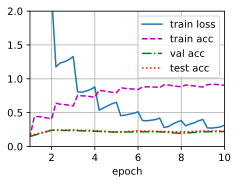

In [ ]:
#without aug and plus the validation loader

lr, num_epochs = 0.001, 10

train(ResNeXt_1(), Train_loader, Validation_loader , Test_loader, num_epochs, lr, device=d2l.try_gpu())

In [ ]:
# save the model
torch.save(ResNeXt_1, '/content/drive/MyDrive/deep_learning/PROGETTO/ResNeXt_1.pt')

In [ ]:
# load the model
ResNeXt_1 = torch.load( '/content/drive/MyDrive/deep_learning/PROGETTO/ResNeXt_1.pt')

Since we have overfitting we skip the evaluation of the model through the confusion matrix and we proceed directly with the augmentation.

## Resnext: Train the model with augmented data

loss 1.314, train acc 0.651, val acc 0.334, test acc 0.341
86.2 examples/sec on cpu


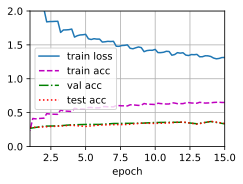

In [ ]:
#with aug 
lr, num_epochs = 0.001, 15
train(ResNeXt_1(), New_Train_loader,Validation_loader, Test_loader, num_epochs, lr, device=d2l.try_gpu())

In [ ]:
# save the model
torch.save(ResNeXt_1(), '/content/drive/MyDrive/deep_learning/PROGETTO/ResNext_model_aug.pt')

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
# load the model
ResNext_model_aug = torch.load('/content/drive/MyDrive/deep_learning/PROGETTO/ResNext_model_aug.pt')

With the use of augmented data, we reduce the overfitting problem. By looking at the the confusion matrix above we can see that the model is not good enough to make predictions. So we sohould go further in the analysis.

# Googlenet

Googlenet is a convolutional naural network based on the Inception architeture, that is structured by four convolutons that work in parallel and we need to define. Once that incepion block is defined we will construct the building block to define the class of the neaural network in leaner way.

In [ ]:
from d2l import torch as d2l
import torch
from torch import nn

# build inception blocks
from torch.nn import functional as F

class Inception(nn.Module):
    def __init__(self, input_ch, output_ch1, output_ch2, output_ch3, output_ch4, **kwargs): 
        super(Inception, self).__init__(**kwargs)
        # Build 4 parallel paths
        # Path 1: it uses a 1x1 convolutional layer
        self.p1_1 = nn.Conv2d(input_ch, output_ch1, kernel_size=1) 
        # Path 2: is a 1x1 convolutional layer and it reduces the number of channels,
        # followed by a 3 x 3 convolutional layer
        self.p2_1 = nn.Conv2d(input_ch, output_ch2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(output_ch2[0], output_ch2[1], kernel_size=3, padding=1)
        # Path 3: is a 1 x 1 convolutional layer and it reduces the number of channels,
        # followed by a 5 x 5 convolutional layer
        self.p3_1 = nn.Conv2d(input_ch, output_ch3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(output_ch3[0], output_ch3[1], kernel_size=5, padding=2)
        # Path 4: is a 3 x 3 maximum pooling layer followed by a 1 x 1 convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(input_ch, output_ch4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x)))) 
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.BatchNorm2d(192),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Dropout(0.4),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Dropout(p=0.5), nn.Linear(1024, 21), nn.LogSoftmax(dim = 1))

In [ ]:
# show layers
X = torch.rand(size=(1, 3, 100, 100))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 25, 25])
Sequential output shape:	 torch.Size([1, 192, 13, 13])
Sequential output shape:	 torch.Size([1, 480, 7, 7])
Sequential output shape:	 torch.Size([1, 832, 4, 4])
Sequential output shape:	 torch.Size([1, 1024])
Dropout output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 21])
LogSoftmax output shape:	 torch.Size([1, 21])


In [ ]:
#CV with not augmented data
Cross_Validation(net = net)

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
Starting epoch 2
Training process has finished.
Starting testing
Accuracy for fold 0: 13 %
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1
Starting epoch 2
Training process has finished.
Starting testing
Accuracy for fold 1: 13 %
--------------------------------
FOLD 2
--------------------------------
Starting epoch 1
Starting epoch 2
Training process has finished.
Starting testing
Accuracy for fold 2: 4 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS
--------------------------------
Fold 0: 13.49368120668569 %
Fold 1: 13.62153344208809 %
Fold 2: 4.486133768352365 %
Average: 10.533782805708716 %


In [ ]:
#CV with augmented data
Cross_Validation(net= net, data = new_dataset)

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 2.852
Starting epoch 2
Loss after mini-batch   500: 2.336
Training process has finished.
Starting testing
Accuracy for fold 0: 26 %
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 2.765
Starting epoch 2
Loss after mini-batch   500: 2.321
Training process has finished.
Starting testing
Accuracy for fold 1: 29 %
--------------------------------
FOLD 2
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 2.802
Starting epoch 2
Loss after mini-batch   500: 2.382
Training process has finished.
Starting testing
Accuracy for fold 2: 26 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS
--------------------------------
Fold 0: 26.3506625891947 %
Fold 1: 29.02436537873382 %
Fold 2: 26.679579977571617 %
Average: 27.35153598183338 %


## Train the model

Let's now train the choosen model with the non-augmented dataset

loss 0.710, train acc 0.758, val acc 0.676, test acc 0.679
40.6 examples/sec on cpu


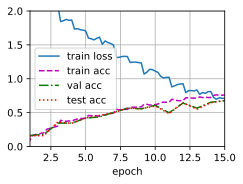

In [ ]:
#without aug and plus the validation loader
lr, num_epochs = 0.001, 15
train(net, Train_loader,Validation_loader, Test_loader, num_epochs, lr, device=d2l.try_gpu())

The model performs similarly on the validation and test sets, it indicates that the model has not overfit the training data and is likely to generalize well to new unseen data. 

In [ ]:
# save the model
torch.save(net, '/content/drive/MyDrive/deep_learning/PROGETTO/GoogleNet_model.pt')

In [ ]:
# load the model
GoogleNet_model = torch.load( '/content/drive/MyDrive/deep_learning/PROGETTO/GoogleNet_model.pt')

### Evaluate the model

In [ ]:
# make prediction
for x, y in Test_loader:
  break
#x , y = x.cuda(), y.cuda()
pred = torch.exp(GoogleNet_model(x)).argmax(axis=1)

<Axes: title={'center': 'GoogLeNet Confusion Matrix Augmented'}, xlabel='Predicted label', ylabel='True label'>

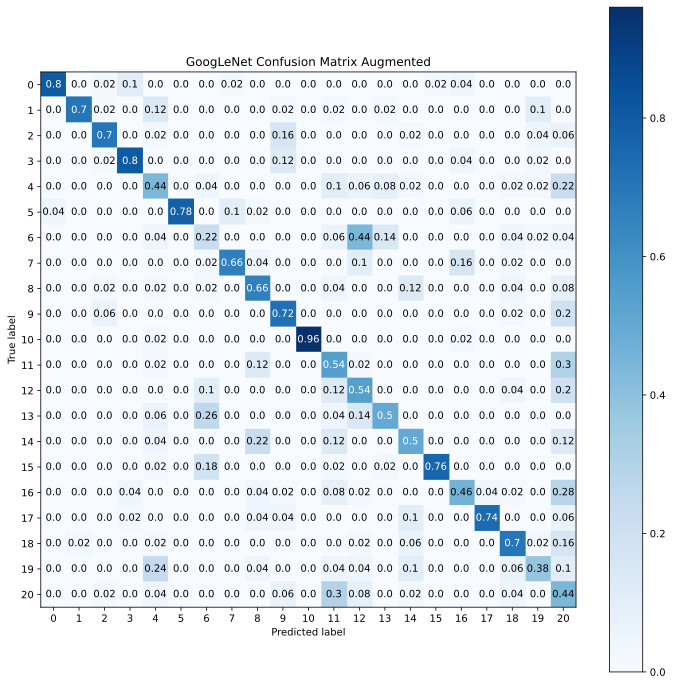

In [ ]:
GoogleNet_model.to('cpu')
y_true = []
y_pred = []

for x, y in Test_loader:
    pred_aug = torch.exp(GoogleNet_model(x)).argmax(axis=1)
    y_true += y.cpu().numpy().tolist()
    y_pred += pred_aug.cpu().numpy().tolist()

# compute the confusion matrix
import scikitplot as skplt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
skplt.metrics.plot_confusion_matrix(y_true, y_pred, normalize=True, cmap='Blues', figsize=(12, 12), title='GoogLeNet Confusion Matrix Augmented')


As we can see the model is capable in identify the correct label, but we can improve this predictions with the use of augmented data

## Googlenet: Train the model with augmented data

loss 0.404, train acc 0.881, val acc 0.886, test acc 0.869
30.0 examples/sec on cpu


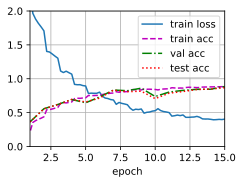

In [ ]:
#with aug 
lr, num_epochs = 0.001, 15
train(net, New_Train_loader,Validation_loader, Test_loader, num_epochs, lr, device=d2l.try_gpu())

As we can see from the output above, we get highest value for the test accuracy (0.869) as we expect before

In [ ]:
# save the model
torch.save(net, '/content/drive/MyDrive/deep_learning/PROGETTO/GoogleNet_model_aug.pt')

In [ ]:
# load the model
GoogleNet_model_aug = torch.load('/content/drive/MyDrive/deep_learning/PROGETTO/GoogleNet_model_aug.pt')

### Evaluate the model

<Axes: title={'center': 'GoogLeNet Confusion Matrix Augmented'}, xlabel='Predicted label', ylabel='True label'>

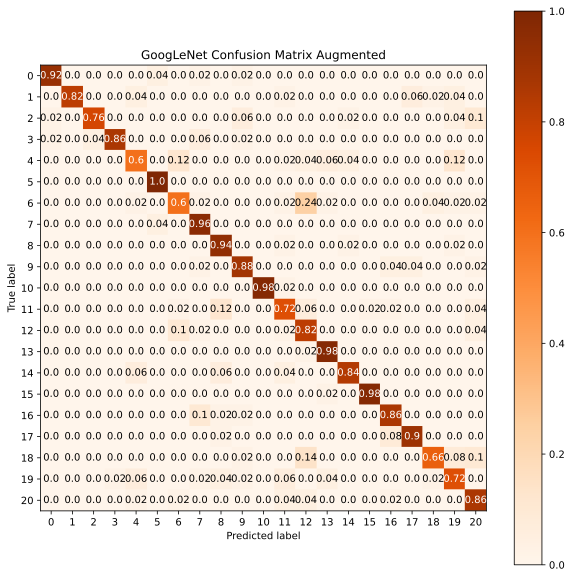

In [ ]:
GoogleNet_model_aug.to('cpu')
y_true = []
y_pred = []

for x, y in Test_loader:
    pred_aug = torch.exp(GoogleNet_model_aug(x)).argmax(axis=1)
    y_true += y.cpu().numpy().tolist()
    y_pred += pred_aug.cpu().numpy().tolist()

# compute the confusion matrix
import scikitplot as skplt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
skplt.metrics.plot_confusion_matrix(y_true, y_pred, normalize=True, cmap='Oranges', figsize=(10, 10), title='GoogLeNet Confusion Matrix Augmented')


The confusion matrix above is almost perfect, only some classes are not fully estimated in the correct way.

#Summary

After traininig three different models we can conclude that the best one for our data is Googlenet. Lenet and AlexNet underfit, probably it is too simple to detect this complicate images. On the other hand Resnext ovefits the data as test accuracy is much lower than the train accuracy. 
Now that we have found a model with accettable perfomance we are going to test it in some applications to see how it behaves in different contexts.

# Possible applications

This model could be useful to make classification of images taken from real maps, in order to check if it is capable in performing this task we decided to apply it with both real images and AI generated ones.

## Classifiation on generated images

To perform this task we rely on [DALL-E](https://labs.openai.com/), which is an AI system that can create realistic images and art from a description in natural language.


In [ ]:
#function for guessing the true label
def from_generated_img(readable):

  generated_image = imread(readable)
  print(type(generated_image))
  img = generated_image
  preprocc = transforms.Compose([transforms.ToTensor(),transforms.Resize([100,100])])
  tensor = preprocc(img)
  tensor = tensor.reshape(1, 3, 100, 100)

  output = GoogleNet_model_aug(tensor)
  print(output)

  _, preds = torch.max(output, 1)
  print(preds[0])
  print(type(preds))
  preds = preds.squeeze()
  print(preds)
  print(type(preds))

  print(f"the predicted label is: {preds.item()} , which corresponds to the label {swapped_dictionary[preds.item()]}")

  plt.imshow(generated_image)
  plt.title(f"Predicted label: {swapped_dictionary[preds.item()]}")

tensor([[-14.1610,  -8.9042, -10.1191, -15.4092,  -6.4776, -12.8138,  -2.5819,
         -10.7601, -12.2553,  -8.4753, -11.7735,  -4.8225,  -0.3783,  -5.7316,
         -10.9534,  -7.5836,  -8.5247, -15.0002,  -2.1402,  -7.0741,  -2.2360]],
       grad_fn=<LogSoftmaxBackward0>)
tensor(12)
the predicted label is: 12 , which corresponds to the label mobilehomepark


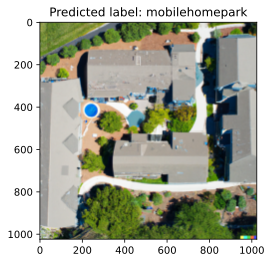

In [ ]:
#First image
gen_dir = "/content/drive/MyDrive/deep_learning/PROGETTO/real_images/DALL·E 2023-03-08 05.07.53 - satellite images of a medium residential.png"
from_generated_img(gen_dir)

tensor([[-8.7039, -6.5940, -6.3928, -2.5279, -6.5820, -9.2110, -8.5359, -8.8563,
         -8.2968, -3.5926, -2.1090, -6.9356, -9.2741, -9.2577, -7.8560, -8.8098,
         -0.3514, -2.9060, -6.4483, -5.6138, -7.3017]],
       grad_fn=<LogSoftmaxBackward0>)
tensor(16)
the predicted label is: 16 , which corresponds to the label runway


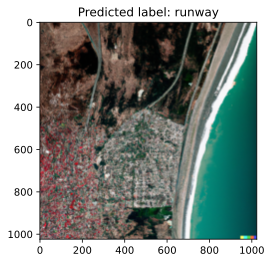

In [ ]:
#second image
gen_dir2 = "/content/drive/MyDrive/deep_learning/PROGETTO/AI_Generated_Images/DALL·E 2023-01-29 15.06.45 - satellite images of a city with a beach.png"
from_generated_img(gen_dir2)

tensor([[-1.2899e+01, -9.5062e+00, -1.1216e+01, -9.0241e+00, -6.7617e+00,
         -1.0364e+01, -8.1652e+00, -1.2963e+01, -1.3707e+01, -8.9922e+00,
         -6.3507e-03, -9.4017e+00, -1.1074e+01, -7.3312e+00, -1.3088e+01,
         -7.5178e+00, -5.8440e+00, -9.0818e+00, -9.7451e+00, -9.1545e+00,
         -1.0008e+01]], grad_fn=<LogSoftmaxBackward0>)
tensor(10)
the predicted label is: 10 , which corresponds to the label intersection


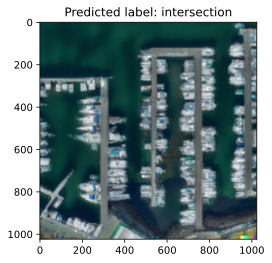

In [ ]:
#third image
gen_dir3 = "/content/drive/MyDrive/deep_learning/PROGETTO/AI_Generated_Images/DALL·E 2023-01-29 15.09.13 - satellite images of an harbor with boats.png"
from_generated_img(gen_dir3)

As we can see if the generated image is quite precise, the model is able to detect which kind of object it is.
The common mistake that we can see from the previous examples are:

- The image is usually generated from a more distant point of view and this feature does not allow the model to focus on a single object. (in gen_dir2 there are at least three possible classes like for example Beach, Dense Residential and Runway)

- that the generated image is not enough detailed as a real picture (in gen_dir3 is difficult to distinguish boats, in fact the model recognize water as a street and maybe boats as buildings)

## Google Earth

Let's focus now on real images taken from Google Earth 

tensor([[ -1.0828,  -9.7577,  -8.3402,  -4.6638,  -8.9156,  -0.9519,  -7.1300,
          -1.4475,  -7.5920,  -6.8359,  -7.6020,  -9.7085,  -8.1242,  -9.7758,
         -10.0661,  -7.4791,  -3.7880,  -6.8064,  -6.8169,  -7.0575,  -7.2465]],
       grad_fn=<LogSoftmaxBackward0>)
tensor(5)
the predicted label is: 5 , which corresponds to the label chaparral


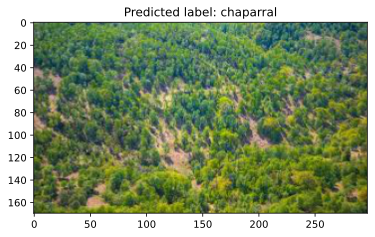

In [ ]:
#first real image
real_dir = "/content/drive/MyDrive/deep_learning/PROGETTO/real_images/chapparal.jpeg"
from_generated_img(real_dir)

tensor([[-3.0380, -3.0203, -3.0382, -3.0261, -3.0608, -3.0267, -3.0421, -3.0574,
         -3.0920, -3.0293, -3.0620, -3.0498, -3.0158, -3.0517, -3.0917, -3.0504,
         -3.0152, -3.0467, -3.0328, -3.0759, -3.0173]],
       grad_fn=<LogSoftmaxBackward0>)
tensor(16)
the predicted label is: 16 , which corresponds to the label runway


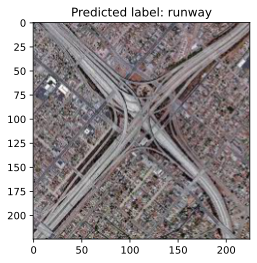

In [ ]:
#second real image
real_dir_2 = "/content/drive/MyDrive/deep_learning/PROGETTO/real_images/cross.jpeg"
from_generated_img(real_dir_2)

We decided to take also an image from the NASA's website from which are taken the images of the dataset ([Landsat Image Gallery](https://landsat.visibleearth.nasa.gov/)) in order to see if the quality of the image could help the model in predicting the correct label.

In particular we took the images available in the article about dimantled boats at the following [link](https://landsat.visibleearth.nasa.gov/view.php?id=84447)

tensor([[-3.0623, -3.0401, -3.0242, -3.0033, -3.0564, -3.0375, -3.0436, -3.0755,
         -3.0663, -3.0309, -3.0330, -3.0465, -3.0230, -3.0654, -3.0859, -3.0213,
         -3.0271, -3.0638, -3.0298, -3.0737, -3.0302]],
       grad_fn=<LogSoftmaxBackward0>)
tensor(3)
the predicted label is: 3 , which corresponds to the label beach


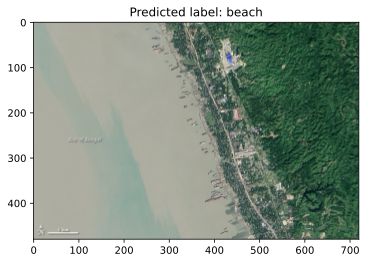

In [ ]:
#third image
real_dir_1 = "/content/drive/MyDrive/deep_learning/PROGETTO/real_images/bangladesh_oli_2013335.jpg"
from_generated_img(real_dir_1)

All the real images are correctly classified.